<figure>
<img src="../Imagenes/logo-final-ap.png"  width="80" height="80" align="left"/> 
</figure>

# <span style="color:blue"><left>Aprendizaje Profundo</left></span>

# <span style="color:red"><center>BERTAS</center></span>

<center>Pytorch-lightning model</center>

##   <span style="color:blue">Autores</span>

1. Alvaro Mauricio Montenegro Díaz, ammontenegrod@unal.edu.co
2. Daniel Mauricio Montenegro Reyes, dextronomo@gmail.com 

## <span style="color:blue">Referencias</span> 

1. [HuggingFace. Transformers ](https://huggingface.co/transformers/)
1. [HuggingFace. Intro pipeline](https://huggingface.co/course/chapter1/3?fw=pt)
1. [Sentence transformer](https://github.com/UKPLab/sentence-transformers)
1. [SBERT paper](https://arxiv.org/pdf/1908.10084.pdf)
1. [SBERT.net](https://www.sbert.net/)

## <span style="color:blue">Contenido</span>

* [Introducción](#Introducción)
* 

## <span style="color:blue">Introduction</span>

The data was previously pre-processed in such a way that in this section we will use the clean and corrected data. They will be the basis for the sentence-embeddings.

We will use Sentence-Transformer 

In [201]:
import pandas as pd
import numpy as np
import h5py
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import os
from torch import nn
import torch.nn.functional as F
import pytorch_lightning as pl
from glob import glob

In [202]:
# path of hdf5 files containig complete datasets inf hdf5 files
path_data_hdf5 = '../Datos/Datasets_hdf5/'
files_all = sorted(glob(f'{path_data_hdf5}F*'))
files_narrative = files_all[:2] + files_all[6:]
files_depend = files_all[2:6]

In [226]:
# path of hdf5 files containig complete datasets inf hdf5 files
path_data_hdf5 = '../Datos/Datasets_Longformer/'
files_all = sorted(glob(f'{path_data_hdf5}F*'))
files_narrative = files_all[:2] + files_all[6:]
files_depend = files_all[2:6]

In [227]:
files_all

['../Datos/Datasets_Longformer/F1_ds_1783.hdf5',
 '../Datos/Datasets_Longformer/F2_ds_1800.hdf5',
 '../Datos/Datasets_Longformer/F3_ds_1726.hdf5',
 '../Datos/Datasets_Longformer/F4_ds_1772.hdf5',
 '../Datos/Datasets_Longformer/F5_ds_1805.hdf5',
 '../Datos/Datasets_Longformer/F6_ds_1800.hdf5',
 '../Datos/Datasets_Longformer/F7_ds_1569.hdf5',
 '../Datos/Datasets_Longformer/F8_ds_723.hdf5']

In [228]:
class EssayDataset(Dataset):
    """
    inputs:
    hdf5_files: list of hdf5 files containing the 
    data: embeddings
    target: latent traits
    global_score: available holistic score. Original score/10
    trait_mean: computed average for the latent trais
    target_scale: boolean: if True, rescale target values to [0,1] interval
    
    output: data and the latent traits.
    
    be careful, because 
    narratively essays have 5 traits. Files F1, F2, F7 and F8
    depended essays have 4 traits. Files F3, F4, F5 and F6
      
    """
    def __init__(self, hdf5_files, target_scale=True):
        self.hdf5_files = hdf5_files
        self.x = None
        self.y = None
                
        self.process_data()
        
        # Scale Target
        if target_scale:
            self.target_scale()

    
    def process_data(self):
        for i, file in enumerate(self.hdf5_files):
            f = h5py.File(file, mode='r')
            x = f['data']
            y = f['target']
            if i == 0:
                self.x = x
                self.y = y
            else:
                self.x = np.vstack((self.x, x)).astype(np.float32)
                self.y = np.vstack((self.y, y)).astype(np.float32)
    
    def target_scale(self):
        """
        Original target values are 1, 2, 3, 4, 5, 6
        """
        self.y = ((self.y-1.0)/5.0).astype(np.float32)
        
    def __len__(self):
        return self.y.shape[0]
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        return self.x[idx], self.y[idx]

In [229]:
class EssayDatasetTrait(Dataset):
    """
    inputs:
    hdf5_files: list of hdf5 files containing the 
    data: embeddings
    target: latent traits
    global_score: available holistic score. Original score/10
    trait_mean: computed average for the latent trais
    target_scale: boolean: if True, rescale target values to [0,1] interval
    
    output: data and the selected latent trait.
    
    be careful, because 
    narratively essays have 5 traits. Files F1, F2, F7 and F8
    depended essays have 4 traits. Files F3, F4, F5 and F6
      
    """
    def __init__(self, hdf5_files, trait,target_scale=True):
        self.hdf5_files = hdf5_files
        self.x = None
        self.y = None
        self.trait = trait - 1 # For Translating Human to Python
        
        self.process_data()
        
        # Scale Target
        if target_scale:
            self.target_scale()

    
    def process_data(self):
        for i, file in enumerate(self.hdf5_files):
            f = h5py.File(file, mode='r')
            x = f['data']
            y = f['target']
            if i == 0:
                self.x = x
                self.y = y[:,trait]
            else:
                self.x = np.vstack((self.x, x)).astype(np.float32)
                self.y = np.vstack((self.y, y[:,self.trait])).astype(np.float32)
    
    def target_scale(self):
        """
        Original target values are 1, 2, 3, 4, 5, 6
        """
        self.y = ((self.y-1.0)/5.0).astype(np.float32)
        
    def __len__(self):
        return self.y.shape[0]
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        return self.x[idx], self.y[idx]

In [230]:
class EssayDatasetMeanTrait(Dataset):
    """
    inputs:
    hdf5_files: list of hdf5 files containing the 
    data: embeddings
    target: latent traits
    global_score: available holistic score. Original score/10
    trait_mean: computed average for the latent trais
    target_scale: boolean: if True, rescale target values to [0,1] interval
    
    output: data and the the average of the latent traits.
    
    be careful, because 
    narratively essays have 5 traits. Files F1, F2, F7 and F8
    depended essays have 4 traits. Files F3, F4, F5 and F6
      
    """
    def __init__(self, hdf5_files , target_scale=True):
        self.hdf5_files = hdf5_files
        self.x = None
        self.y = None
                
        self.process_data()
        
        # Scale Target
        if target_scale:
            self.target_scale()

    
    def process_data(self):
        for i, file in enumerate(self.hdf5_files):
            f = h5py.File(file, mode='r')
            x = f['data']
            y = f['trait_mean']
            if i == 0:
                self.x = x
                self.y = y
            else:
                self.x = np.vstack((self.x, x)).astype(np.float32)
                self.y = np.vstack((self.y, y)).astype(np.float32)
    
    def target_scale(self):
        """
        Original target values are 1, 2, 3, 4, 5, 6
        """
        self.y = ((self.y-1.0)/5.0).astype(np.float32)
        
    def __len__(self):
        return self.y.shape[0]
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        return self.x[idx], self.y[idx]

In [231]:
class EssayDatasetGlobalScore(Dataset):
    """
    inputs:
    hdf5_files: list of hdf5 files containing the 
    data: embeddings
    target: latent traits
    global_score: available holistic score. Original score/10
    trait_mean: computed average for the latent trais
    target_scale: boolean: if True, rescale target values to [0,1] interval
    
    output: data and the the holistic global score
    
    be careful, because 
    narratively essays have 5 traits. Files F1, F2, F7 and F8
    depended essays have 4 traits. Files F3, F4, F5 and F6
      
    """
    def __init__(self, hdf5_files , target_scale=True):
        self.hdf5_files = hdf5_files
        self.x = None
        self.y = None
                
        self.process_data()
        
        # Scale Target
        if target_scale:
            self.target_scale()

    
    def process_data(self):
        for i, file in enumerate(self.hdf5_files):
            f = h5py.File(file, mode='r')
            x = f['data']
            y = f['global_score']
            if i == 0:
                self.x = x
                self.y = y
            else:
                self.x = np.vstack((self.x, x)).astype(np.float32)
                self.y = np.vstack((self.y, y)).astype(np.float32)
    
    def target_scale(self):
        """
        Original target values are 1, 2, 3, 4, 5, 6
        """
        self.y = ((self.y-1.0)/5.0).astype(np.float32)
        
    def __len__(self):
        return self.y.shape[0]
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        return self.x[idx], self.y[idx]

### class SampleDataset

In [232]:
class SampleDataset(Dataset):
    """
    inputs:
    dataset: dataset to obtain the sample
    idx: index of the sample
    """
    def __init__(self, dataset, idx):
        self.x , self.y = dataset[idx]

    def __len__(self):
        return self.y.shape[0]  
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        return self.x[idx], self.y[idx]

### Datasets

In [233]:
print(files_all)
print()
print(files_narrative)
print()
print(files_depend)

['../Datos/Datasets_Longformer/F1_ds_1783.hdf5', '../Datos/Datasets_Longformer/F2_ds_1800.hdf5', '../Datos/Datasets_Longformer/F3_ds_1726.hdf5', '../Datos/Datasets_Longformer/F4_ds_1772.hdf5', '../Datos/Datasets_Longformer/F5_ds_1805.hdf5', '../Datos/Datasets_Longformer/F6_ds_1800.hdf5', '../Datos/Datasets_Longformer/F7_ds_1569.hdf5', '../Datos/Datasets_Longformer/F8_ds_723.hdf5']

['../Datos/Datasets_Longformer/F1_ds_1783.hdf5', '../Datos/Datasets_Longformer/F2_ds_1800.hdf5', '../Datos/Datasets_Longformer/F7_ds_1569.hdf5', '../Datos/Datasets_Longformer/F8_ds_723.hdf5']

['../Datos/Datasets_Longformer/F3_ds_1726.hdf5', '../Datos/Datasets_Longformer/F4_ds_1772.hdf5', '../Datos/Datasets_Longformer/F5_ds_1805.hdf5', '../Datos/Datasets_Longformer/F6_ds_1800.hdf5']


In [234]:
dataset = EssayDataset(files_narrative, target_scale=False)

# sanity check

dataset[10][1]

array([5., 5., 5., 4., 5.], dtype=float32)

In [235]:
dataset = EssayDataset(files_depend, target_scale=False)

# sanity check

dataset[10][1]

array([3., 3., 2., 3.], dtype=float32)

In [236]:
dataset = EssayDatasetMeanTrait(files_all, target_scale=False)

dataset[10][1]

array([4.8], dtype=float32)

In [237]:
len(dataset)

12978

## <span style="color:blue">Global Score Experiment</span>

In [134]:
dataset = EssayDatasetGlobalScore(files_all, target_scale=False)

dataset[10][1]

array([0.8], dtype=float32)

In [167]:
np.argwhere(np.isnan(dataset[:][1]))

array([], shape=(0, 2), dtype=int64)

In [238]:
# samples for trainig, validation and test
size_data = len(dataset)
percent_valid = 0.1
percent_test = 0.1
percent_training = 0.8

valid_size = int(size_data * percent_valid)
test_size = int(size_data * percent_valid)
training_size = size_data - valid_size - test_size 
print ('valid size = ', valid_size, ' test size = ', test_size,' training size = ', training_size)

valid size =  1297  test size =  1297  training size =  10384


In [239]:
# reproductibity
np.random.seed(100)
# sample validation and test
valid_test_indices = np.random.choice(np.arange(size_data), size = valid_size + test_size, replace=False)
# separate validation and test
valid_index = valid_test_indices[:valid_size]
test_index = valid_test_indices[valid_size:]
# training indexes
training_index = np.setdiff1d(np.arange(size_data), valid_test_indices , assume_unique=False)

In [240]:
len(training_index)

10384

In [241]:
# sanity check
print(valid_index.shape, test_index.shape, training_index.shape)

(1297,) (1297,) (10384,)


In [242]:
# datasets

training_dataset = SampleDataset(dataset, training_index )
valid_dataset = SampleDataset(dataset, valid_index )
test_dataset = SampleDataset(dataset, test_index )

In [243]:
test_dataset[0][1]

array([2.75], dtype=float32)

In [244]:
# dataloaders

In [245]:
train_dataloader = DataLoader(training_dataset, batch_size=32, shuffle=True, num_workers=64)
valid_dataloader = DataLoader(valid_dataset, batch_size=32, shuffle=False, num_workers=64)
test_dataloader  = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=64)

In [246]:
len(training_dataset)

10384

## <span style="color:blue">Load required modules</span>

In [267]:
class BERTAS(pl.LightningModule):
    def __init__(self,num_traits=1,test_dl = test_dataloader):
        super().__init__()
        
        self.num_traits = num_traits
        self.test = test_dataloader
        # Each trait separately
        self.trait_1 = nn.Sequential(nn.Linear(1024, 256),
                                     nn.ReLU(),
                                     nn.Dropout(0.2),
                                     nn.Linear(256, 64),
                                     nn.ReLU(), 
                                     nn.Dropout(0.2), 
                                     nn.Linear(64,self.num_traits),
                                     nn.ReLU())
        self.elu = nn.ELU()
        self.relu = nn.ReLU()
        self.dpout = nn.Dropout(0.2)
        self.l1 = nn.Linear(768, 256)
        self.l2 = nn.Linear(256, 64)
        self.l3 = nn.Linear(64, self.num_traits)
        
        
        
        
        
    def forward(self,x):
        # in lightning, forward defines the prediction/inference actions
        #scores = torch.cat([self.trait_1(x),self.trait_2(x),self.trait_3(x),self.trait_4(x),self.trait_5(x)],axis=1)
        scores = self.trait_1(x)
        return scores

    def training_step(self, batch, batch_idx):
        # training_step defined the train loop.
        # It is independent of forward
        x,y = batch
        #scores = torch.cat([self.trait_1(x),self.trait_2(x),self.trait_3(x),self.trait_4(x),self.trait_5(x)],axis=1)
        scores = self.trait_1(x)
        loss = F.mse_loss(scores, y)
        # Logging to TensorBoard by default
        self.log("train_loss", loss, on_epoch=True, prog_bar=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        scores = self(x)
        val_loss = F.mse_loss(scores, y)
        self.log("val_loss", val_loss, on_epoch=True, prog_bar=True)
    
    def test_step(self, batch, batch_idx):
        x, y = batch
        scores = self(x)
        test_loss = F.mse_loss(scores, y)
        self.log("test_loss", test_loss, on_epoch=True, prog_bar=True)
        
    def test_dataloader(self):
        return self.test

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=1e-3)
        lr_scheduler = {
        'scheduler': torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,mode='min',
                                                               factor=0.2,
                                                               patience=5,
                                                               min_lr=1e-6,
                                                               verbose=True),
        'name': 'lr_scheduler','monitor':"val_loss"
        }
        return [optimizer], [lr_scheduler]

In [250]:
class BERTAS_2(pl.LightningModule):
    def __init__(self,num_traits=1,test_dl = test_dataloader):
        super().__init__()
        
        self.num_traits = num_traits
        self.test = test_dataloader
        # Each trait separately
        self.trait_1 = nn.Sequential(nn.Linear(1024, 256),
                                     nn.ReLU(),
                                     nn.Dropout(0.2),
                                     nn.Linear(256, 64),
                                     nn.ReLU(), 
                                     nn.Dropout(0.2), 
                                     nn.Linear(64,self.num_traits),
                                     nn.ReLU())
        self.elu = nn.ELU()
        self.relu = nn.ReLU()
        self.dpout = nn.Dropout(0.2)
        self.l1 = nn.Linear(768, 256)
        self.l2 = nn.Linear(256, 64)
        self.l3 = nn.Linear(64, self.num_traits)
        
        
        
        
        
    def forward(self,x):
        # in lightning, forward defines the prediction/inference actions
        #scores = torch.cat([self.trait_1(x),self.trait_2(x),self.trait_3(x),self.trait_4(x),self.trait_5(x)],axis=1)
        scores = self.trait_1(x)
        return scores

    def training_step(self, batch, batch_idx):
        # training_step defined the train loop.
        # It is independent of forward
        x,y = batch
        #scores = torch.cat([self.trait_1(x),self.trait_2(x),self.trait_3(x),self.trait_4(x),self.trait_5(x)],axis=1)
        scores = self.trait_1(x)
        loss = F.mse_loss(scores, y)
        # Logging to TensorBoard by default
        self.log("train_loss", loss, on_epoch=True, prog_bar=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        scores = self(x)
        val_loss = F.mse_loss(scores, y)
        self.log("val_loss", val_loss, on_epoch=True, prog_bar=True)
    
    def test_step(self, batch, batch_idx):
        x, y = batch
        scores = self(x)
        test_loss = F.mse_loss(scores, y)
        self.log("test_loss", test_loss, on_epoch=True, prog_bar=True)
        
    def test_dataloader(self):
        return self.test

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=1e-3)
        lr_scheduler = {
        'scheduler': torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,mode='min',
                                                               factor=0.2,
                                                               patience=5,
                                                               min_lr=1e-6,
                                                               verbose=True),
        'name': 'lr_scheduler','monitor':"val_loss"
        }
        return [optimizer], [lr_scheduler]

In [268]:
auto_score = BERTAS(test_dl = test_dataloader)

In [269]:
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor

lr_monitor = LearningRateMonitor(logging_interval='epoch')

stopping_threshold = 0.2
early_stopping = EarlyStopping('val_loss',verbose=True,stopping_threshold=stopping_threshold,patience=20)

# Trainer for gpu training
trainer = pl.Trainer(accelerator="gpu",strategy='dp',max_epochs=40,callbacks=[lr_monitor, early_stopping])
trainer.fit(model=auto_score, train_dataloaders=train_dataloader,val_dataloaders=valid_dataloader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name    | Type       | Params
---------------------------------------
0 | trait_1 | Sequential | 278 K 
1 | elu     | ELU        | 0     
2 | relu    | ReLU       | 0     
3 | dpout   | Dropout    | 0     
4 | l1      | Linear     | 196 K 
5 | l2      | Linear     | 16.4 K
6 | l3      | Linear     | 65    
---------------------------------------
492 K     Trainable params
0         Non-trainable params
492 K     Total params
1.969     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/bizon/anaconda3/envs/sentence_transformers/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (_ResultMetric). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_no_full_state`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if `full_state_update=False` can be used safely.
                
  warnings.warn(*args, **kwargs)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 0.863


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.418 >= min_delta = 0.0. New best score: 0.444


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.027 >= min_delta = 0.0. New best score: 0.417


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.015 >= min_delta = 0.0. New best score: 0.402


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.400


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.398


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.042 >= min_delta = 0.0. New best score: 0.355


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.020 >= min_delta = 0.0. New best score: 0.336


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.327


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 00025: reducing learning rate of group 0 to 2.0000e-04.


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 00031: reducing learning rate of group 0 to 4.0000e-05.


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 00037: reducing learning rate of group 0 to 8.0000e-06.


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 20 records. Best score: 0.327. Signaling Trainer to stop.


In [259]:
trainer.test(auto_score)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing: 0it [00:00, ?it/s]

/home/bizon/anaconda3/envs/sentence_transformers/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (_ResultMetric). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_no_full_state`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if `full_state_update=False` can be used safely.
                
  warnings.warn(*args, **kwargs)


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.3094162344932556
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.3094162344932556}]

In [266]:
auto_score = BERTAS(test_dl = test_dataloader)
new_model = auto_score.load_from_checkpoint(checkpoint_path="./lightning_logs/version_5/checkpoints/epoch=39-step=13000.ckpt")

In [261]:
preds = auto_score(torch.tensor(np.array(training_dataset.x))).detach().numpy()
y = torch.tensor(np.array(training_dataset.y))

In [262]:
preds

array([[3.5097013],
       [3.4898038],
       [3.7625337],
       ...,
       [4.518358 ],
       [3.99716  ],
       [3.6356454]], dtype=float32)

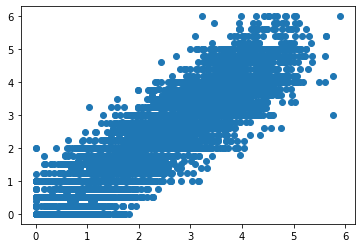

In [263]:
import matplotlib.pyplot as plt

plt.plot(preds[:,0],y[:,0],'o');

In [264]:
np.corrcoef(preds[:,0],y[:,0])

array([[1.        , 0.88765738],
       [0.88765738, 1.        ]])